# Machine Learning Model Analysis

The purpose of this analysis is to provide the best machine learning model for Morgan Stanley to predict the likihood if tomorrow's closing price being higher or lower than today's closing price

I am going to use Black rock's maximum of data available to train and test the model

In [1]:
# Importing Libraries
# Data Handling
import pandas as pd
import numpy as np
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as mtick
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)# Financial Data Analysis
import yfinance as yf
import ta
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Models
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier # Hiding warnings
import warnings 
warnings.filterwarnings("ignore")

In [2]:
# Loading Morgan Stanley stocks until Aug 29th, 2023
ms = yf.download('MS', end = '2023-09-13')
ms

[*********************100%%**********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
1993-02-23   8.000000   8.125000   7.656250   7.750000   3.736161  40594800
1993-02-24   7.875000   8.062500   7.781250   7.968750   3.841613   9426400
1993-02-25   8.000000   8.156250   7.968750   8.156250   3.932005   5229200
1993-02-26   8.156250   8.281250   8.031250   8.281250   3.992266   2761200
1993-03-01   8.187500   8.218750   8.000000   8.000000   3.856680   3014400
...               ...        ...        ...        ...        ...       ...
2023-09-06  84.279999  84.750000  83.349998  84.160004  84.160004   5384000
2023-09-07  83.989998  84.870003  83.779999  83.839996  83.839996   5504200
2023-09-08  84.150002  84.949997  83.660004  84.919998  84.919998   6127600
2023-09-11  85.379997  85.669998  83.349998  83.510002  83.510002   7780900
2023-09-12  83.339996  86.529999  83.230003  85.550003  85.550003   8942600

[7694 rows x 6 columns]

In [3]:
open_data = ms['Open']
high_data = ms['High']
low_data = ms['Low']
close_data = ms['Close']
dates = ms.index  

trace = go.Candlestick(x=dates,
                open=open_data,
                high=high_data,
                low=low_data,
                close=close_data)

layout = go.Layout(
    title='BlackRock Stock Price (Candlestick)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Price (in USD)'),
    plot_bgcolor='rgba(230, 230, 230, 0.8)',  # Setting a background color for better clarity
)

fig = go.Figure(data=[trace], layout=layout)


fig.show()


In [4]:
# Data Splitting
train = ms[ms.index.year <= 2010] 
test = ms[ms.index.year >= 2011]

In [5]:
# Adding Close_Shift Variable
train['Close_Shift'] = train['Adj Close'].shift(1) 
test['Close_Shift'] = test['Adj Close'].shift(1)

In [6]:
# Adding Daily Returns variable
train['Return'] = (train['Adj Close']/train['Close_Shift'] - 1) * 100 
test['Return'] = (test['Adj Close']/test['Close_Shift'] - 1) * 100

In [7]:
# Creating target variable on both datasets
train['target'] = np.where(train['Return'].shift(-1) > 0, 1, 0) 
test['target'] = np.where(test['Return'].shift(-1) > 0, 1, 0)

In [8]:
X_train = train.drop('target', axis = 1)  # Selecting Predictor Variables
y_train = train['target']  # Selecting Target Variable

X_test = test.drop('target', axis = 1)  # Selecting Predictor Variables
y_test = test['target']  # Selecting Target Variable

In [9]:
# Defining feature engineering function
def feature_engineering(df):
# Adding Simple Moving Averages
    df['sma5'] = ta.trend.sma_indicator(df['Adj Close'],window = 5) 
    df['sma10'] = ta.trend.sma_indicator(df['Adj Close'],window = 10) 
    df['sma15'] = ta.trend.sma_indicator(df['Adj Close'],window = 15) 
    df['sma20'] = ta.trend.sma_indicator(df['Adj Close'],window = 20) 
    df['sma30'] = ta.trend.sma_indicator(df['Adj Close'],window = 30) 
    df['sma50'] = ta.trend.sma_indicator(df['Adj Close'],window = 50) 
    df['sma80'] = ta.trend.sma_indicator(df['Adj Close'],window = 80) 
    df['sma100'] = ta.trend.sma_indicator(df['Adj Close'],window = 100) 
    df['sma200'] = ta.trend.sma_indicator(df['Adj Close'],window = 200)
    # Adding Price to Simple Moving Averages ratios
    df['sma5_ratio'] = df['Adj Close'] / df['sma5'] 
    df['sma10_ratio'] = df['Adj Close'] / df['sma10'] 
    df['sma20_ratio'] = df['Adj Close'] / df['sma20']
    df['sma30_ratio'] = df['Adj Close'] / df['sma30'] 
    df['sma50_ratio'] = df['Adj Close'] / df['sma50'] 
    df['sma80_ratio'] = df['Adj Close'] / df['sma80'] 
    df['sma100_ratio'] = df['Adj Close'] / df['sma100'] 
    df['sma200_ratio'] = df['Adj Close'] / df['sma200']

    # Adding RSI, CCI, Bollinger Bands, and OBV
    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.volatility.BollingerBands(df['Adj Close'])
    df['bb_high'] = bb_indicator.bollinger_hband()
    df['bb_low'] = bb_indicator.bollinger_lband()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()
    # Adding features derived from the indicators above
    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int) 
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int) 
    df['above_bb_high'] = (df['Adj Close'] >= df['bb_high']).astype(int) 
    df['below_bb_low'] = (df['Adj Close'] <= df['bb_low']).astype(int)
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close' ].diff().rolling(10).sum()
    df['obv_divergence_20_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close' ].diff().rolling(20).sum()
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)
    df['sma5 > sma10'] = (df['sma5'] > df['sma10']).astype(int) 
    df['sma10 > sma15'] = (df['sma10'] > df['sma15']).astype(int) 
    df['sma15 > sma20'] = (df['sma15'] > df['sma20']).astype(int) 
    df['sma20 > sma30'] = (df['sma20'] > df['sma30']).astype(int)
    df['sma30 > sma50'] = (df['sma30'] > df['sma50']).astype(int) 
    df['sma50 > sma80'] = (df['sma50'] > df['sma80']).astype(int) 
    df['sma80 > sma100'] = (df['sma80'] > df['sma100']).astype(int) 
    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)
    # Removing NaN values from the dataframe
    df.dropna(inplace = True) 
    return df

In [10]:
# Applying function to the X_train and X_test sets
X_train = feature_engineering(X_train)
X_test = feature_engineering(X_test)

In [11]:
# Removing from y_train and y_test the NaN values that were dropped from X_train and X_t est by the index
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]

In [12]:
# Creating a list of different classification models
classifiers = [
    LogisticRegression(random_state = 42), 
    XGBClassifier(random_state = 42), 
    LGBMClassifier(random_state = 42), 
    CatBoostClassifier(random_state = 42, verbose = False), 
    AdaBoostClassifier(random_state = 42), 
    RandomForestClassifier(random_state = 42)
]
# Iterating over classifiers in the list above, training, and evaluating them
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_pred) 
    print(f'{type(clf).__name__}: AUC Score={auc_score:.3f}')

LogisticRegression: AUC Score=0.513
XGBClassifier: AUC Score=0.517
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2128, number of negative: 2173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8188
[LightGBM] [Info] Number of data points in the train set: 4301, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494769 -> initscore=-0.020926
[LightGBM] [Info] Start training from score -0.020926
LGBMClassifier: AUC Score=0.517
CatBoostClassifier: AUC Score=0.510
AdaBoostClassifier: AUC Score=0.514
RandomForestClassifier: AUC Score=0.521


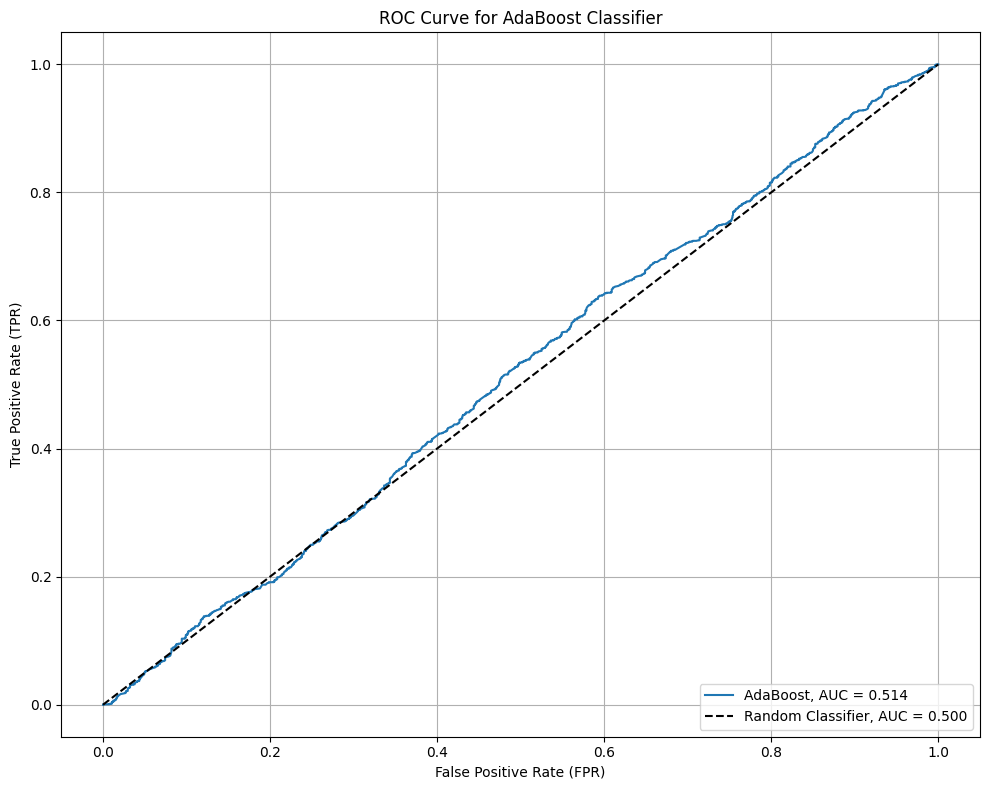

In [13]:
# Train AdaBoostClassifier and get the probabilities for the positive class
clf = AdaBoostClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, label=f"AdaBoost, AUC = {auc(fpr, tpr):.3f}")
plt.plot([0,1], [0,1], 'k--', label="Random Classifier, AUC = 0.500")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for AdaBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

AUC = 0.5: This suggests no discrimination, which means the model's prediction is no better than random guessing. It's akin to flipping a coin. In your results, LogisticRegression and RandomForestClassifier have AUCs very close to 0.5, suggesting they're not providing any meaningful discrimination for the dataset you've provided.

0.5 < AUC < 1: This indicates some discrimination power, with higher values being better. An AUC of 1 indicates a perfect classifier, where it can perfectly separate the two classes. In practice, an AUC score above 0.8 or 0.9 is considered excellent. In your results, none of the models achieved a high AUC. The highest AUC you have is from AdaBoostClassifier with an AUC of 0.515, which suggests very minimal predictive power beyond random guessing.

AUC < 0.5: Technically, this indicates a model that's doing worse than random guessing. However, you can invert its predictions to achieve an AUC greater than 0.5. In most real-world applications, an AUC less than 0.5 indicates that something may be wrong with the data preprocessing or the way the model is trained.

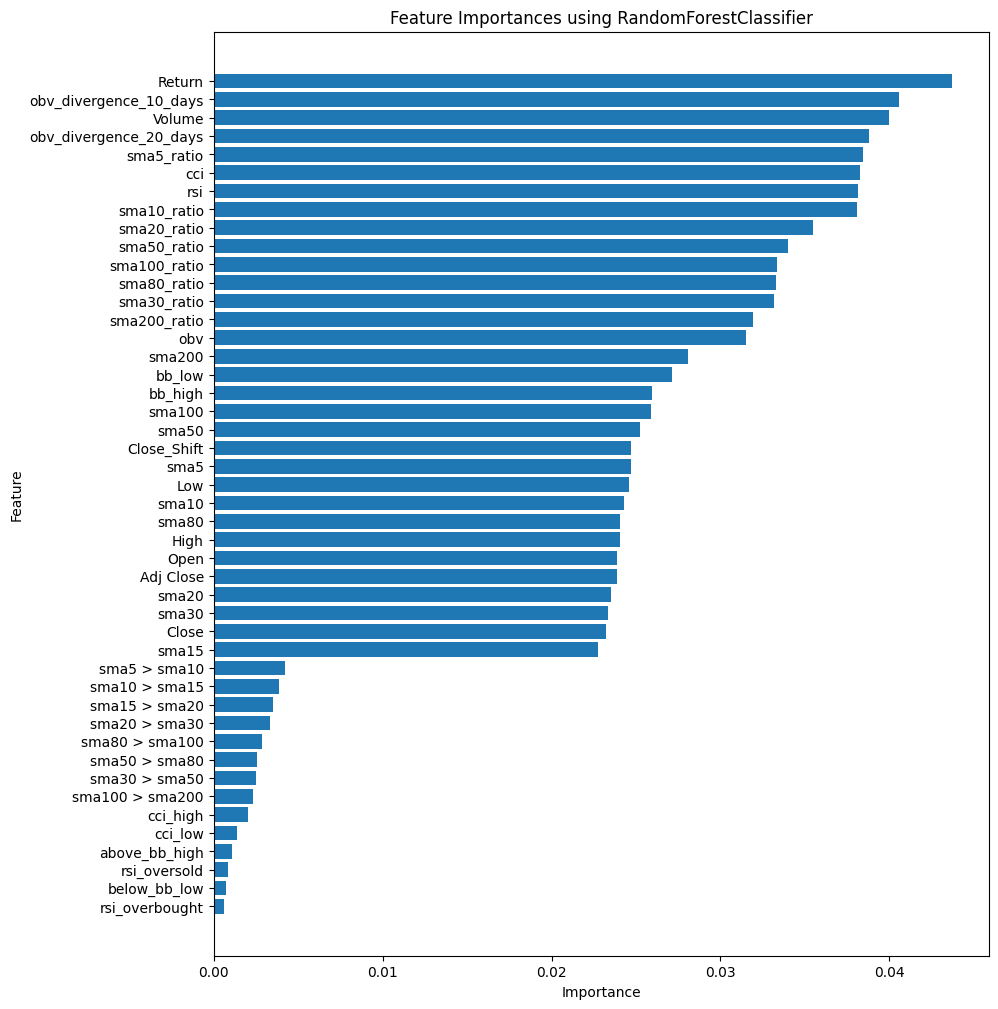

In [14]:
# Train a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_

# Get the indices of the sorted feature importances
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(10, 12))
plt.barh(range(X_train.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances using RandomForestClassifier')
plt.show()


In [15]:
quantile_intervals = np.arange(0, 1.125, 0.125) # Creating intervals for the quantiles 
quantile_values = np.quantile(y_pred_proba, quantile_intervals) # Dividing y_pred in 8 different quantiles

classes = pd.cut(y_pred_proba, quantile_values) # Grouping probabilities according to the quantiles
X_test['y_true'] = y_test # Creating a new column in the X_test set containing the true label values
table = pd.crosstab(classes, X_test['y_true']) # Creating a table counting true labels according to each probability range

print(table)

y_true            0    1
row_0                   
(0.366, 0.479]  197  178
(0.479, 0.485]  169  204
(0.485, 0.488]  208  168
(0.488, 0.498]  178  197
(0.498, 0.499]  168  205
(0.499, 0.5]    168  205
(0.5, 0.501]    194  181
(0.501, 0.567]  170  204


In [16]:
sign = np.zeros_like(y_pred_proba) # Creating an array with 0s in the same length as y_pred
# Short selling signal
sign[((y_pred_proba >= 0.3477) & (y_pred_proba < 0.5087)) | ((y_pred_proba > 0.5189) & (y_pred_proba < 0.5195) )] = -1
# Buying signal
sign[((y_pred_proba >= 0.5087) & (y_pred_proba <= 0.5189)) |
((y_pred_proba >= 0.5195) & (y_pred_proba <= 0.5252))] = 1
# Display signal values
sign

array([-1., -1., -1., ..., -1., -1., -1.])

In [17]:
X_test.drop('y_true', axis=1, inplace=True, errors='ignore')

adb = AdaBoostClassifier(random_state=42)

adb.fit(X_train, y_train)

X_test['model_returns'] = adb.predict(X_test)

X_test.head(8) # Displaying X_test set

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2011-10-17  15.180000  15.390000  15.000000  15.250000  11.787616  29580900   
2011-10-18  15.550000  16.940001  15.450000  16.629999  12.854300  51760300   
2011-10-19  17.070000  17.719999  16.400000  16.639999  12.862028  66831000   
2011-10-20  16.610001  16.770000  16.000000  16.610001  12.838840  35380300   
2011-10-21  16.920000  17.200001  16.730000  17.020000  13.155749  33004700   
2011-10-24  17.299999  17.420000  16.910000  17.150000  13.256239  26051800   
2011-10-25  16.930000  16.969999  16.459999  16.520000  12.769270  23647600   
2011-10-26  16.969999  17.040001  16.360001  16.639999  12.862028  30490700   

            Close_Shift    Return       sma5      sma10  ...  cci_low  \
Date                                                     ...            
2011-10-17    11.764426  0.197116  11.878823  11.597467  ...        0   
2011-10-18    11.787616  9.049198  12.070518  11.799982  ...        0   
2011-10-19    12.854300  0.060117  12.194192  11.966941  ...        0   
2011-10-20    12.862028 -0.180287  12.421442  12.077474  ...        0   
2011-10-21    12.838840  2.468368  12.699707  12.292357  ...        0   
2011-10-24    13.155749  0.763846  12.993431  12.436127  ...        0   
2011-10-25    13.256239 -3.673508  12.976425  12.523471  ...        0   
2011-10-26    12.769270  0.726417  12.976425  12.585308  ...        0   

            sma5 > sma10  sma10 > sma15  sma15 > sma20  sma20 > sma30  \
Date                                                                    
2011-10-17             1              1              1              0   
2011-10-18             1              1              1              0   
2011-10-19             1              1              1              0   
2011-10-20             1              1              1              0   
2011-10-21             1              1              1              1   
2011-10-24             1              1              1              1   
2011-10-25             1              1              1              1   
2011-10-26             1              1              1              1   

            sma30 > sma50  sma50 > sma80  sma80 > sma100  sma100 > sma200  \
Date                                                                        
2011-10-17              0              0               0                0   
2011-10-18              0              0               0                0   
2011-10-19              0              0               0                0   
2011-10-20              0              0               0                0   
2011-10-21              0              0               0                0   
2011-10-24              0              0               0                0   
2011-10-25              0              0               0                0   
2011-10-26              0              0               0                0   

            model_returns  
Date                       
2011-10-17              0  
2011-10-18              1  
2011-10-19              0  
2011-10-20              0  
2011-10-21              1  
2011-10-24              0  
2011-10-25              0  
2011-10-26              0  

[8 rows x 47 columns]

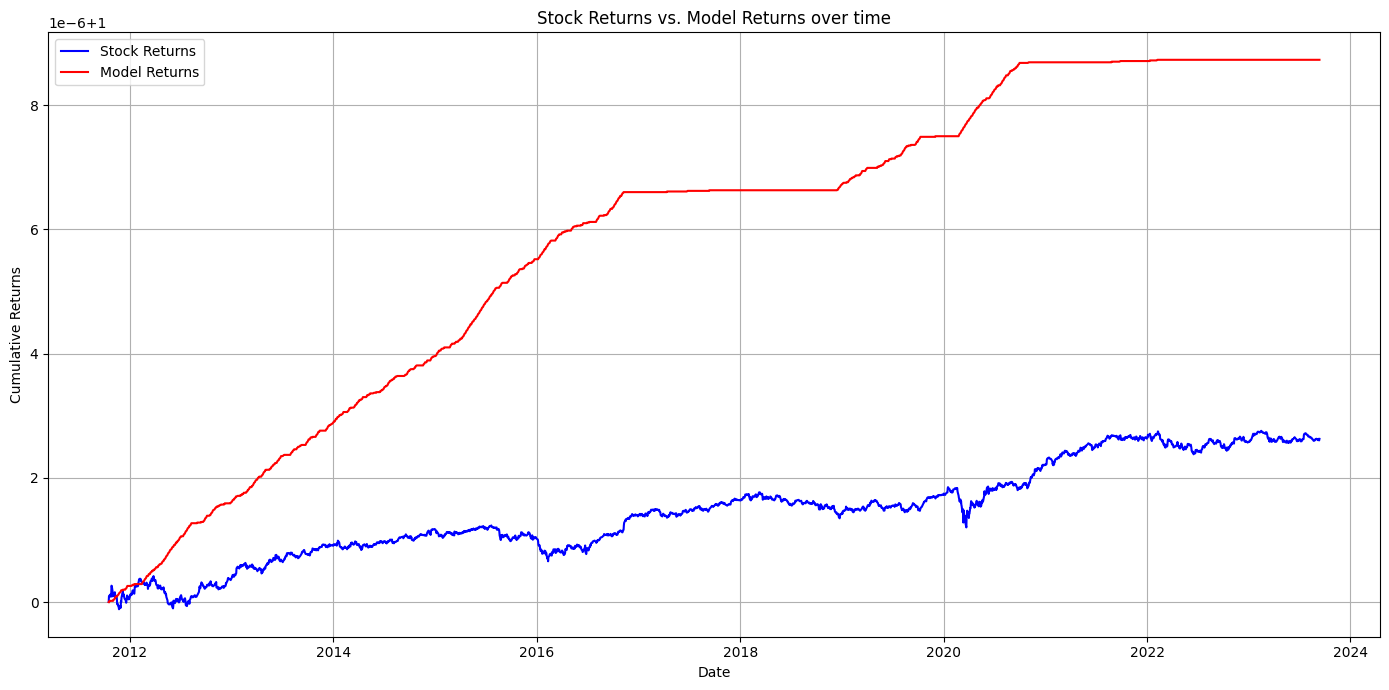

In [18]:

# Assuming you've already created the 'model_returns' column in your X_test dataframe as mentioned in the provided code
# Cumulative returns are a good way to visualize overall performance over time
X_test['cumulative_stock_returns'] = (1 + X_test['Return'] / 100000000).cumprod()
X_test['cumulative_model_returns'] = (1 + X_test['model_returns'] / 100000000).cumprod()

# Now, let's visualize it using matplotlib
plt.figure(figsize=(14, 7))
plt.plot(X_test.index, X_test['cumulative_stock_returns'], label='Stock Returns', color='blue')
plt.plot(X_test.index, X_test['cumulative_model_returns'], label='Model Returns', color='red')
plt.title('Stock Returns vs. Model Returns over time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [20]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
135/135 [==============================] - 8s 37ms/step - loss: 0.2613
Epoch 2/100
135/135 [==============================] - 5s 36ms/step - loss: 0.2539
Epoch 3/100
135/135 [==============================] - 5s 36ms/step - loss: 0.2526
Epoch 4/100
135/135 [==============================] - 5s 36ms/step - loss: 0.2551
Epoch 5/100
135/135 [==============================] - 5s 36ms/step - loss: 0.2540
Epoch 6/100
135/135 [==============================] - 5s 37ms/step - loss: 0.2529
Epoch 7/100
135/135 [==============================] - 5s 37ms/step - loss: 0.2537
Epoch 8/100
135/135 [==============================] - 5s 37ms/step - loss: 0.2528
Epoch 9/100
135/135 [==============================] - 5s 37ms/step - loss: 0.2526
Epoch 10/100
135/135 [==============================] - 5s 37ms/step - loss: 0.2519
Epoch 11/100
135/135 [==============================] - 5s 37ms/step - loss: 0.2526
Epoch 12/100
135/135 [==============================] - 5s 37ms/step - loss: 0.2525
E

In [21]:
real_close_price = ms.iloc[:, 3:4].values
real_close_price

array([[ 7.75      ],
       [ 7.96875   ],
       [ 8.15625   ],
       ...,
       [84.91999817],
       [83.51000214],
       [85.55000305]])

In [22]:
test

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2011-01-03  27.629999  28.570000  27.480000  28.230000  21.694649  21176700   
2011-01-04  28.459999  28.500000  28.000000  28.469999  21.879101  12859900   
2011-01-05  28.360001  28.830000  28.299999  28.830000  22.155750  15101100   
2011-01-06  28.850000  28.980000  28.580000  28.799999  22.132690  13200900   
2011-01-07  28.840000  28.889999  28.000000  28.200001  21.671600  17512600   
...               ...        ...        ...        ...        ...       ...   
2023-09-06  84.279999  84.750000  83.349998  84.160004  84.160004   5384000   
2023-09-07  83.989998  84.870003  83.779999  83.839996  83.839996   5504200   
2023-09-08  84.150002  84.949997  83.660004  84.919998  84.919998   6127600   
2023-09-11  85.379997  85.669998  83.349998  83.510002  83.510002   7780900   
2023-09-12  83.339996  86.529999  83.230003  85.550003  85.550003   8942600   

            Close_Shift    Return  target  
Date                                       
2011-01-03          NaN       NaN       1  
2011-01-04    21.694649  0.850219       1  
2011-01-05    21.879101  1.264446       0  
2011-01-06    22.155750 -0.104081       0  
2011-01-07    22.132690 -2.083299       0  
...                 ...       ...     ...  
2023-09-06    84.839996 -0.801500       0  
2023-09-07    84.160004 -0.380237       1  
2023-09-08    83.839996  1.288170       0  
2023-09-11    84.919998 -1.660382       1  
2023-09-12    83.510002  2.442822       0  

[3194 rows x 9 columns]

In [23]:
training_set = train.iloc[:, 1:2].values

In [24]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [25]:
dataset_total = pd.concat((train['Close'], train['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(46, 62):  # Adjusted from (60, 76) to (46, 62)
    X_test.append(inputs[i-46:i, 0])  # Adjusted from i-60 to i-46
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_close_price = model.predict(X_test)
predicted_close_price = sc.inverse_transform(predicted_close_price)

1/1 [==============================] - 1s 704ms/step


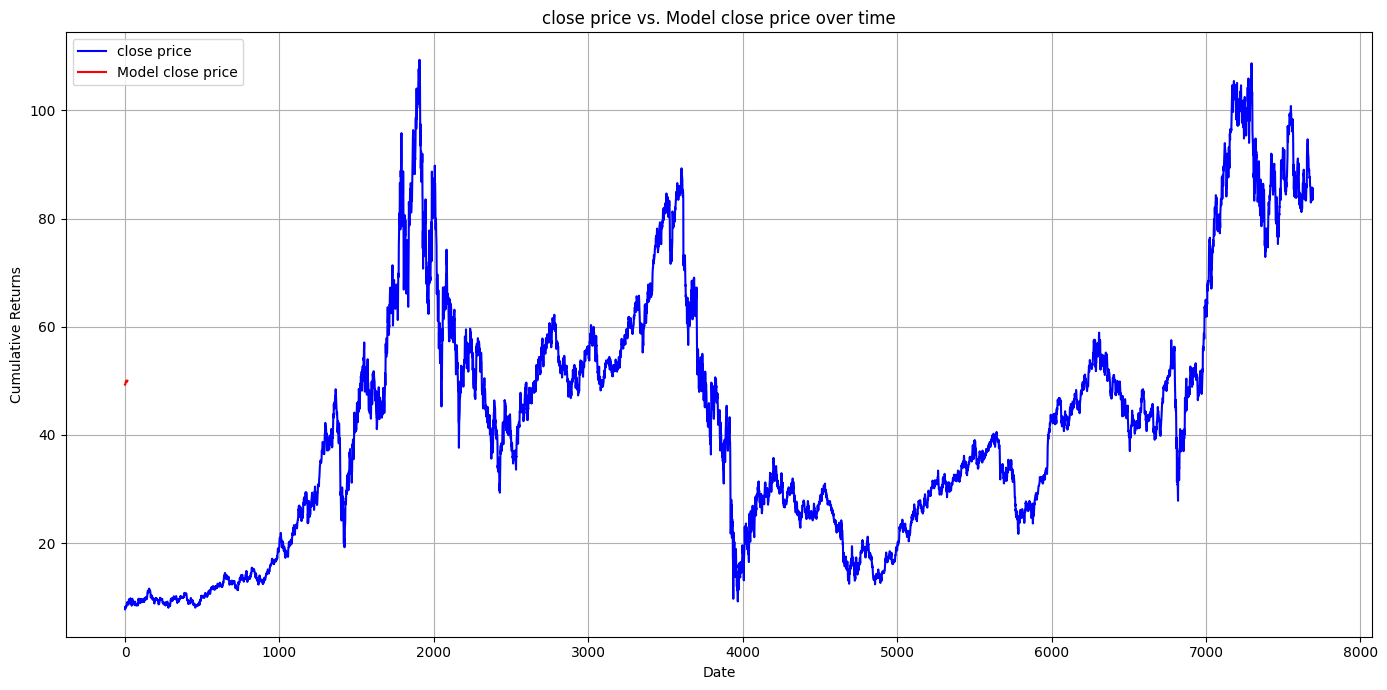

In [26]:
# Now, let's visualize it using matplotlib
plt.figure(figsize=(14, 7))
plt.plot(real_close_price, label='close price', color='blue')
plt.plot(predicted_close_price, label='Model close price', color='red')
plt.title('close price vs. Model close price over time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusion, none of these models are great fit for prediction of the actual stock returns for Morgan Stanley

In [3]:
# Importing libraries
import pandas as pd
import plotly.express as px 
import ydata_profiling as yp
import yfinance as yf
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

In [4]:
# Obtaining data 
df = yf.Ticker('MS')
# Selecting historical prices period
ms = df.history(period='30y') # Last 30 years
# See dataframe
ms

Open       High        Low      Close  \
Date                                                                    
1993-09-15 00:00:00-04:00   4.665429   4.741166   4.589691   4.726019   
1993-09-16 00:00:00-04:00   4.741170   4.953235   4.695727   4.907792   
1993-09-17 00:00:00-04:00   4.907791   5.028971   4.907791   4.998676   
1993-09-20 00:00:00-04:00   5.119858   5.225890   5.044120   5.180448   
1993-09-21 00:00:00-04:00   5.195595   5.347070   5.180448   5.180448   
...                              ...        ...        ...        ...   
2023-09-08 00:00:00-04:00  84.150002  84.949997  83.660004  84.919998   
2023-09-11 00:00:00-04:00  85.379997  85.669998  83.349998  83.510002   
2023-09-12 00:00:00-04:00  83.339996  86.529999  83.230003  85.550003   
2023-09-13 00:00:00-04:00  86.150002  87.800003  86.150002  87.250000   
2023-09-14 00:00:00-04:00  88.080002  89.110001  87.919998  89.070000   

                             Volume  Dividends  Stock Splits  
Date                                                          
1993-09-15 00:00:00-04:00   2201600        0.0           0.0  
1993-09-16 00:00:00-04:00   3288000        0.0           0.0  
1993-09-17 00:00:00-04:00   4284800        0.0           0.0  
1993-09-20 00:00:00-04:00   5114400        0.0           0.0  
1993-09-21 00:00:00-04:00   8490800        0.0           0.0  
...                             ...        ...           ...  
2023-09-08 00:00:00-04:00   6127600        0.0           0.0  
2023-09-11 00:00:00-04:00   7780900        0.0           0.0  
2023-09-12 00:00:00-04:00   8942600        0.0           0.0  
2023-09-13 00:00:00-04:00  10617400        0.0           0.0  
2023-09-14 00:00:00-04:00   8108500        0.0           0.0  

[7554 rows x 7 columns]

In [5]:
# Using Pandas Profiling to generate a report on our dataframe
Profile_1 = yp.ProfileReport(ms)
Profile_1.to_file("Report1(ms).html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
# Removing 'Dividends' and 'Stock Splits' columns
ms = ms.drop(['Dividends','Stock Splits'], axis = 1)
# See results
ms

Open       High        Low      Close  \
Date                                                                    
1993-09-15 00:00:00-04:00   4.665429   4.741166   4.589691   4.726019   
1993-09-16 00:00:00-04:00   4.741170   4.953235   4.695727   4.907792   
1993-09-17 00:00:00-04:00   4.907791   5.028971   4.907791   4.998676   
1993-09-20 00:00:00-04:00   5.119858   5.225890   5.044120   5.180448   
1993-09-21 00:00:00-04:00   5.195595   5.347070   5.180448   5.180448   
...                              ...        ...        ...        ...   
2023-09-08 00:00:00-04:00  84.150002  84.949997  83.660004  84.919998   
2023-09-11 00:00:00-04:00  85.379997  85.669998  83.349998  83.510002   
2023-09-12 00:00:00-04:00  83.339996  86.529999  83.230003  85.550003   
2023-09-13 00:00:00-04:00  86.150002  87.800003  86.150002  87.250000   
2023-09-14 00:00:00-04:00  88.080002  89.110001  87.919998  89.070000   

                             Volume  
Date                                 
1993-09-15 00:00:00-04:00   2201600  
1993-09-16 00:00:00-04:00   3288000  
1993-09-17 00:00:00-04:00   4284800  
1993-09-20 00:00:00-04:00   5114400  
1993-09-21 00:00:00-04:00   8490800  
...                             ...  
2023-09-08 00:00:00-04:00   6127600  
2023-09-11 00:00:00-04:00   7780900  
2023-09-12 00:00:00-04:00   8942600  
2023-09-13 00:00:00-04:00  10617400  
2023-09-14 00:00:00-04:00   8108500  

[7554 rows x 5 columns]

In [7]:
# Adding two simple moving averages in order to increase the number of features to be analyzed by PyCaret Regression models
ms['SMA7'] = ms.Close.rolling(window=7).mean().round(2)
ms['SMA30'] = ms.Close.rolling(window=30).mean().round(2)
# See results
ms

Open       High        Low      Close  \
Date                                                                    
1993-09-15 00:00:00-04:00   4.665429   4.741166   4.589691   4.726019   
1993-09-16 00:00:00-04:00   4.741170   4.953235   4.695727   4.907792   
1993-09-17 00:00:00-04:00   4.907791   5.028971   4.907791   4.998676   
1993-09-20 00:00:00-04:00   5.119858   5.225890   5.044120   5.180448   
1993-09-21 00:00:00-04:00   5.195595   5.347070   5.180448   5.180448   
...                              ...        ...        ...        ...   
2023-09-08 00:00:00-04:00  84.150002  84.949997  83.660004  84.919998   
2023-09-11 00:00:00-04:00  85.379997  85.669998  83.349998  83.510002   
2023-09-12 00:00:00-04:00  83.339996  86.529999  83.230003  85.550003   
2023-09-13 00:00:00-04:00  86.150002  87.800003  86.150002  87.250000   
2023-09-14 00:00:00-04:00  88.080002  89.110001  87.919998  89.070000   

                             Volume   SMA7  SMA30  
Date                                               
1993-09-15 00:00:00-04:00   2201600    NaN    NaN  
1993-09-16 00:00:00-04:00   3288000    NaN    NaN  
1993-09-17 00:00:00-04:00   4284800    NaN    NaN  
1993-09-20 00:00:00-04:00   5114400    NaN    NaN  
1993-09-21 00:00:00-04:00   8490800    NaN    NaN  
...                             ...    ...    ...  
2023-09-08 00:00:00-04:00   6127600  84.85  86.44  
2023-09-11 00:00:00-04:00   7780900  84.60  86.17  
2023-09-12 00:00:00-04:00   8942600  84.65  85.97  
2023-09-13 00:00:00-04:00  10617400  84.87  85.84  
2023-09-14 00:00:00-04:00   8108500  85.47  85.84  

[7554 rows x 7 columns]

In [8]:
# Generating new report with pandas_profiling
Profile_2 = yp.ProfileReport(ms)
Profile_2.to_file("Report2(ms).html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# Using plotly to plot a candlestick chart of the last 30 years
fig = go.Figure(data=[go.Candlestick(x = ms.index,
                                    open = ms.Open,
                                    high = ms.High,
                                    low = ms.Low,
                                    close = ms.Close),
                     go.Scatter(x=ms.index, y = ms.SMA7, line=dict(color='orange',width=1),name='SMA7'),
                     go.Scatter(x=ms.index, y = ms.SMA30, line=dict(color='green',width=1.5),name='SMA30')])
fig.update_layout(title = 'BlackRock stocks from Oct 10th, 1999 to Aug 30th, 2023')
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,)
fig.show()

In [10]:
# Creating a new dataframe containing the last 10 years data to later test how well our predicting model will compare to the closing prices
ms_predict = ms.tail(3000)
# See results
ms_predict

Open       High        Low      Close  \
Date                                                                    
2011-10-12 00:00:00-04:00  12.158634  12.591492  11.857181  12.243660   
2011-10-13 00:00:00-04:00  12.050422  12.050422  11.439785  11.702591   
2011-10-14 00:00:00-04:00  11.888098  11.934475  11.462970  11.764424   
2011-10-17 00:00:00-04:00  11.733507  11.895828  11.594374  11.787614   
2011-10-18 00:00:00-04:00  12.019503  13.093916  11.942207  12.854298   
...                              ...        ...        ...        ...   
2023-09-08 00:00:00-04:00  84.150002  84.949997  83.660004  84.919998   
2023-09-11 00:00:00-04:00  85.379997  85.669998  83.349998  83.510002   
2023-09-12 00:00:00-04:00  83.339996  86.529999  83.230003  85.550003   
2023-09-13 00:00:00-04:00  86.150002  87.800003  86.150002  87.250000   
2023-09-14 00:00:00-04:00  88.080002  89.110001  87.919998  89.070000   

                             Volume   SMA7  SMA30  
Date                                               
2011-10-12 00:00:00-04:00  36426800  11.53  11.66  
2011-10-13 00:00:00-04:00  30447600  11.66  11.60  
2011-10-14 00:00:00-04:00  30698400  11.74  11.55  
2011-10-17 00:00:00-04:00  29580900  11.75  11.53  
2011-10-18 00:00:00-04:00  51760300  12.01  11.57  
...                             ...    ...    ...  
2023-09-08 00:00:00-04:00   6127600  84.85  86.44  
2023-09-11 00:00:00-04:00   7780900  84.60  86.17  
2023-09-12 00:00:00-04:00   8942600  84.65  85.97  
2023-09-13 00:00:00-04:00  10617400  84.87  85.84  
2023-09-14 00:00:00-04:00   8108500  85.47  85.84  

[3000 rows x 7 columns]

In [11]:
# Removing last 2 years from the original dataframe
ms.drop(ms_predict.index,inplace = True)
# See results
ms

Open       High        Low      Close  \
Date                                                                    
1993-09-15 00:00:00-04:00   4.665429   4.741166   4.589691   4.726019   
1993-09-16 00:00:00-04:00   4.741170   4.953235   4.695727   4.907792   
1993-09-17 00:00:00-04:00   4.907791   5.028971   4.907791   4.998676   
1993-09-20 00:00:00-04:00   5.119858   5.225890   5.044120   5.180448   
1993-09-21 00:00:00-04:00   5.195595   5.347070   5.180448   5.180448   
...                              ...        ...        ...        ...   
2011-10-05 00:00:00-04:00  10.682284  11.424324  10.365371  11.192436   
2011-10-06 00:00:00-04:00  11.176978  12.004043  10.759580  11.733508   
2011-10-07 00:00:00-04:00  11.926749  11.965397  10.968280  11.006928   
2011-10-10 00:00:00-04:00  11.401136  11.934477  11.401136  11.818534   
2011-10-11 00:00:00-04:00  11.671670  12.328684  11.501619  11.895828   

                             Volume   SMA7  SMA30  
Date                                               
1993-09-15 00:00:00-04:00   2201600    NaN    NaN  
1993-09-16 00:00:00-04:00   3288000    NaN    NaN  
1993-09-17 00:00:00-04:00   4284800    NaN    NaN  
1993-09-20 00:00:00-04:00   5114400    NaN    NaN  
1993-09-21 00:00:00-04:00   8490800    NaN    NaN  
...                             ...    ...    ...  
2011-10-05 00:00:00-04:00  67720700  10.90  11.87  
2011-10-06 00:00:00-04:00  49437800  10.92  11.84  
2011-10-07 00:00:00-04:00  47983700  10.93  11.77  
2011-10-10 00:00:00-04:00  36348200  10.95  11.74  
2011-10-11 00:00:00-04:00  35000400  11.16  11.69  

[4554 rows x 7 columns]

In [12]:
# Removing NaN
ms.dropna(inplace=True)
# See Results
ms

Open       High        Low      Close  \
Date                                                                    
1993-10-26 00:00:00-04:00   4.847201   4.862349   4.771464   4.832054   
1993-10-27 00:00:00-04:00   4.832053   4.862348   4.816905   4.862348   
1993-10-28 00:00:00-04:00   4.907792   4.953234   4.892644   4.922939   
1993-10-29 00:00:00-04:00   4.938087   4.998677   4.938087   4.983529   
1993-11-01 00:00:00-05:00   4.968380   4.968380   4.832052   4.892642   
...                              ...        ...        ...        ...   
2011-10-05 00:00:00-04:00  10.682284  11.424324  10.365371  11.192436   
2011-10-06 00:00:00-04:00  11.176978  12.004043  10.759580  11.733508   
2011-10-07 00:00:00-04:00  11.926749  11.965397  10.968280  11.006928   
2011-10-10 00:00:00-04:00  11.401136  11.934477  11.401136  11.818534   
2011-10-11 00:00:00-04:00  11.671670  12.328684  11.501619  11.895828   

                             Volume   SMA7  SMA30  
Date                                               
1993-10-26 00:00:00-04:00   4318400   4.92   5.22  
1993-10-27 00:00:00-04:00   1407200   4.89   5.22  
1993-10-28 00:00:00-04:00   2598400   4.89   5.22  
1993-10-29 00:00:00-04:00   2740000   4.92   5.22  
1993-11-01 00:00:00-05:00   1872400   4.91   5.21  
...                             ...    ...    ...  
2011-10-05 00:00:00-04:00  67720700  10.90  11.87  
2011-10-06 00:00:00-04:00  49437800  10.92  11.84  
2011-10-07 00:00:00-04:00  47983700  10.93  11.77  
2011-10-10 00:00:00-04:00  36348200  10.95  11.74  
2011-10-11 00:00:00-04:00  35000400  11.16  11.69  

[4525 rows x 7 columns]

In [13]:
# Importing regression lib from PyCaret
from pycaret.regression import *

In [14]:
setup(data = ms, target = 'Close',session_id=123)

In [15]:
ridge = create_model('ridge',fold = 10)

In [16]:
br = create_model('br',fold=10)

In [17]:
lar = create_model('lar',fold=10)

## Tuning Models

In [18]:
# Tuning ridge
ridge_params = {'alpha' : [0.02,0.024,0.025,0.025,0.026,0.03]}
tune_ridge = tune_model(ridge, n_iter=1000, optimize='RMSE',custom_grid = ridge_params)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [19]:
# Tuning Bayesian Ridge
tune_br = tune_model(br,n_iter=1000, optimize='RMSE')

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [20]:
# Tuning Least Angle Regression 
tune_lar = tune_model(lar,n_iter=1000, optimize='RMSE')

Fitting 10 folds for each of 22 candidates, totalling 220 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## Visualizing Data

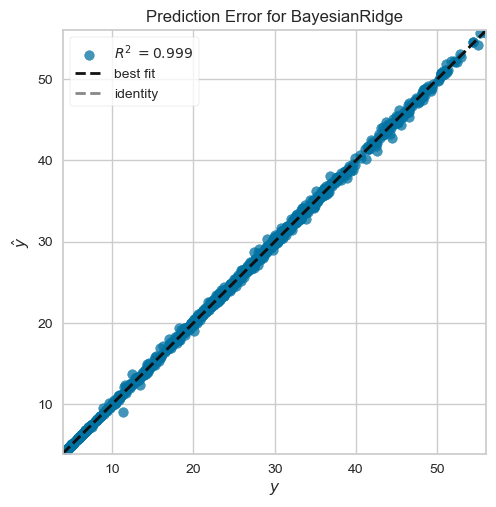

In [21]:
# Error plot
plot_model(tune_br, plot = 'error')

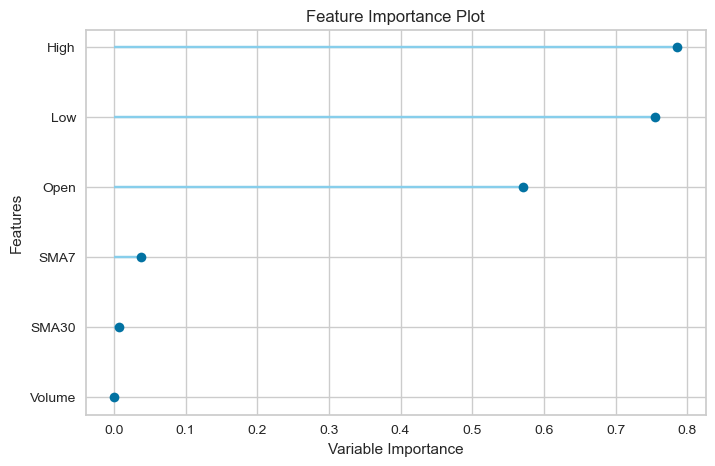

In [22]:
# Importance Feature Plot
plot_model(tune_br, plot = 'feature')

## Finalized Model

In [23]:
# Finalizing model
final_br_model = finalize_model(tune_br)

In [24]:
# Predicting last 2 years
prediction = predict_model(final_br_model,
                          data = ms_predict)
prediction

Open       High        Low    Volume  \
Date                                                                   
2011-10-12 00:00:00-04:00  12.158634  12.591492  11.857181  36426800   
2011-10-13 00:00:00-04:00  12.050422  12.050422  11.439785  30447600   
2011-10-14 00:00:00-04:00  11.888098  11.934475  11.462971  30698400   
2011-10-17 00:00:00-04:00  11.733507  11.895828  11.594375  29580900   
2011-10-18 00:00:00-04:00  12.019504  13.093916  11.942207  51760300   
...                              ...        ...        ...       ...   
2023-09-08 00:00:00-04:00  84.150002  84.949997  83.660004   6127600   
2023-09-11 00:00:00-04:00  85.379997  85.669998  83.349998   7780900   
2023-09-12 00:00:00-04:00  83.339996  86.529999  83.230003   8942600   
2023-09-13 00:00:00-04:00  86.150002  87.800003  86.150002  10617400   
2023-09-14 00:00:00-04:00  88.080002  89.110001  87.919998   8108500   

                                SMA7      SMA30      Close  prediction_label  
Date                                                                          
2011-10-12 00:00:00-04:00  11.530000  11.660000  12.243660         12.300570  
2011-10-13 00:00:00-04:00  11.660000  11.600000  11.702591         11.612083  
2011-10-14 00:00:00-04:00  11.740000  11.550000  11.764424         11.636341  
2011-10-17 00:00:00-04:00  11.750000  11.530000  11.787614         11.793363  
2011-10-18 00:00:00-04:00  12.010000  11.570000  12.854298         12.899780  
...                              ...        ...        ...               ...  
2023-09-08 00:00:00-04:00  84.849998  86.440002  84.919998         84.389007  
2023-09-11 00:00:00-04:00  84.599998  86.169998  83.510002         84.005582  
2023-09-12 00:00:00-04:00  84.650002  85.970001  85.550003         85.811208  
2023-09-13 00:00:00-04:00  84.870003  85.839996  87.250000         87.383087  
2023-09-14 00:00:00-04:00  85.470001  85.839996  89.070000         88.649404  

[3000 rows x 8 columns]

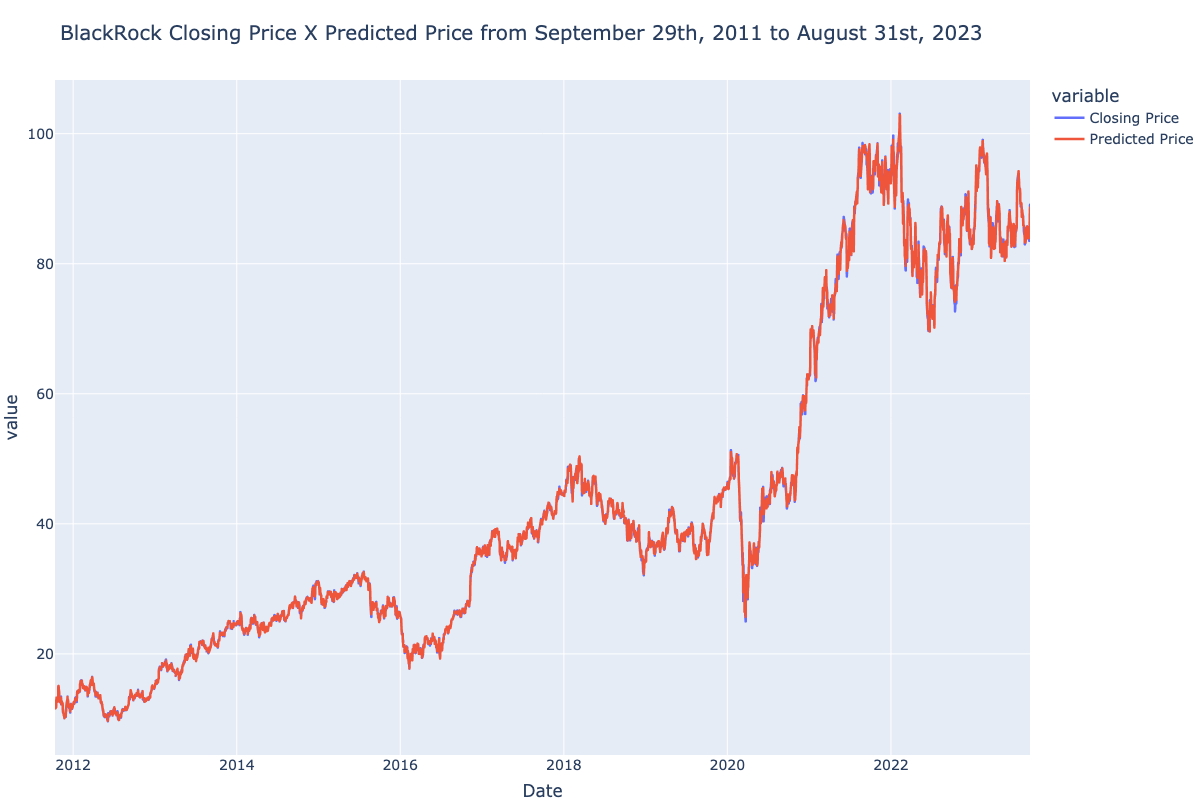

In [25]:
# Round the necessary columns first
prediction['Close'] = prediction['Close'].round(2)
prediction['prediction_label'] = prediction['prediction_label'].round(2)

fig = px.line(prediction, 
              x=prediction.index, 
              y=['Close', 'prediction_label'], 
              title='BLK close price x predicted price from September 29th, 2011 to August 31st, 2023')

newnames = {'Close':'Closing Price', 'prediction_label': 'Predicted Price'}  # Updated the mapping
fig.for_each_trace(lambda t: t.update(name=newnames[t.name],
                                      legendgroup=newnames[t.name],
                                      hovertemplate=t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.update_traces(line=dict(width=2.5))
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    title='BlackRock Closing Price X Predicted Price from September 29th, 2011 to August 31st, 2023',
    margin=dict(l=0, r=0, t=80, b=0),
    font=dict(size=14)
)
fig.show("png")


### Conclusion

Now this model is much better, I found that the Pycaret makes it the easy way to do all the modeling for predictions